In [1]:
%%capture
!pip install -U transformers 
!pip install -U datasets 
!pip install -U accelerate 
!pip install -U peft 
!pip install -U trl 
!pip install -U bitsandbytes 
!pip install -U wandb
!pip install -U bitsandbytes
!pip install -U huggingfaces

In [2]:
!pip install -U peft 

In [8]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    pipeline,
)
from datasets import load_dataset
import torch
import wandb
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
from peft import LoraConfig, get_peft_model


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [9]:
from huggingface_hub import login

# Log in using your Hugging Face token
token = "your_token"
login(token)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Binary classification

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model for sequence classification (binary classification: 0 or 1)
model = AutoModelForSequenceClassification.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", num_labels=2)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [19]:
from datasets import load_dataset, DatasetDict

def load_datasets(train_file_path,validation_file_path,test_file_path, test_ssc_file_path):
    """
    Load train, test, and ssc test datasets from CSV files.

    Args:
        train_file_path (str): Path to the training dataset CSV file.
        test_file_path (str): Path to the balanced testing dataset CSV file.
        test_ssc_file_path (str): Path to the ssc testing dataset csv file.

    Returns:
        DatasetDict: A dictionary containing the training and testing datasets.
    """
    try:
        # Load the training dataset
        train_dataset = load_dataset('csv', data_files=train_file_path)['train']
        print("Train Dataset Loaded Successfully.")

        # Load the balanced testing dataset
        test_dataset = load_dataset('csv', data_files=test_file_path)['train']  # Accessing 'train' because it returns 'train'
        print("Test Dataset Loaded Successfully.")
        
        # Load the ssc testing dataset
        test_ssc_dataset = load_dataset('csv', data_files=test_ssc_file_path)['train']
        print("Test SSC Dataset Loaded Successfully.")

        # Load the validation dataset
        validation_dataset = load_dataset('csv', data_files=validation_file_path)['train']
        print("Validation Dataset Loaded Successfully.")

        # Create a DatasetDict
        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': validation_dataset,
            'test': test_dataset,  # Balanced test dataset
            'test_ssc': test_ssc_dataset  # SSC test dataset
        })

        return dataset_dict

    except Exception as e:
        print("An error occurred while loading the datasets:", str(e))
        return None


# Example usage
train_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_train_dataset.csv'  
validation_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_validation_dataset.csv'
test_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_test_dataset.csv'
test_ssc_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_social_science_test_dataset.csv'

# Load the datasets
datasets = load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path)

# Check if datasets are loaded successfully
if datasets:
    print("Datasets loaded successfully!")
else:
    print("Failed to load datasets.")


Train Dataset Loaded Successfully.
Test Dataset Loaded Successfully.
Test SSC Dataset Loaded Successfully.
Validation Dataset Loaded Successfully.
Datasets loaded successfully!


In [20]:
datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 13736
    })
    validation: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 1962
    })
    test: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 3926
    })
    test_ssc: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 192
    })
})

In [21]:
import pandas as pd

def show_label_and_source_distribution(datasets):
    # Check label and source distribution for each dataset in the dataset_dict
    for split, dataset in datasets.items():
        # Convert dataset to a Pandas DataFrame to easily work with
        df = pd.DataFrame(dataset)
        
        # Check if the label column exists and print the distribution
        if 'label' in df.columns:
            print(f"Label distribution for {split} dataset:")
            print(df['label'].value_counts())
            print("\n")
        else:
            print(f"No label column found in {split} dataset.\n")
        
        # Print the distribution of sentences per source
        if 'source' in df.columns:
            print(f"Sentence distribution per source for {split} dataset:")
            print(df['source'].value_counts())
            print("\n")
        else:
            print(f"No source column found in {split} dataset.\n")

# Call the function to display both label and source distributions for each dataset
show_label_and_source_distribution(datasets)


Label distribution for train dataset:
label
1    6868
0    6868
Name: count, dtype: int64


Sentence distribution per source for train dataset:
source
semeval            4945
Haber              1985
Pubmed data.csv    1787
Press_Release      1322
esl2               1270
ctb                1009
Ssc                 599
altlex              547
because             272
Name: count, dtype: int64


Label distribution for validation dataset:
label
1    981
0    981
Name: count, dtype: int64


Sentence distribution per source for validation dataset:
source
semeval            712
Haber              268
Pubmed data.csv    236
Press_Release      216
ctb                175
esl2               168
Ssc                 80
altlex              69
because             38
Name: count, dtype: int64


Label distribution for test dataset:
label
1    1963
0    1963
Name: count, dtype: int64


Sentence distribution per source for test dataset:
source
semeval            1459
Haber               609
Pubmed data.cs

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set the pad token to be the same as eos_token if it is not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Confirm pad_token and eos_token are set
print(f"Pad Token: {tokenizer.pad_token}")
print(f"EOS Token: {tokenizer.eos_token}")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'], 
        truncation=True, 
        padding="max_length",  # ensure padding is applied
        max_length=150,
        return_tensors='pt'    # return pytorch tensors
    )

# Assuming datasets is already loaded as a DatasetDict
# Tokenize the datasets
datasets = datasets.map(tokenize_function, batched=True)

# Set the format for PyTorch
datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Print a sample to ensure everything is set up correctly
print(datasets['train'][0])

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pad Token: <|eot_id|>
EOS Token: <|eot_id|>


Map:   0%|          | 0/13736 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

Map:   0%|          | 0/3926 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

{'label': tensor(1), 'input_ids': tensor([128000,   1687,   1766,    912,   9678,  15360,    315,  26617,  21934,
           449,    220,   5326,    315,  10672,  14499,   8624,    477,  51658,
          8952,   2065,    304,    420,  29334,   7187,     13, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
      

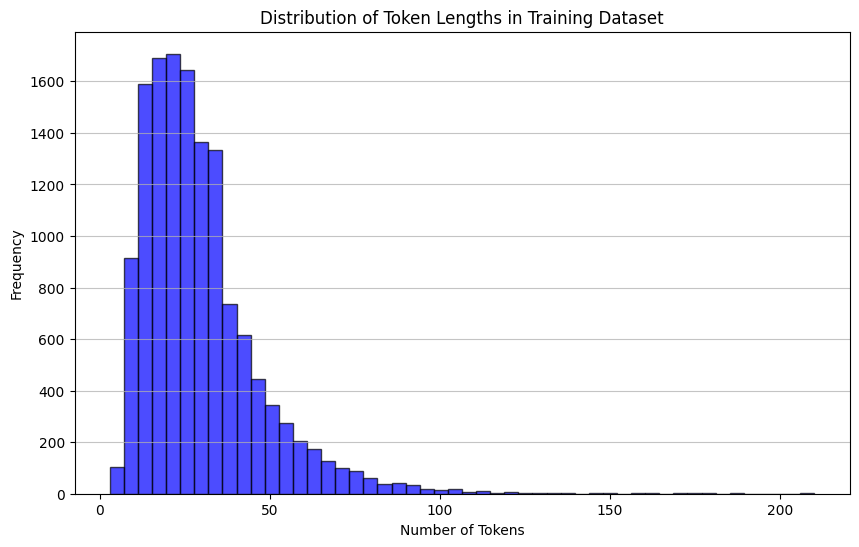

Max token length: 210
Min token length: 3
Average token length: 29.44


In [23]:
import matplotlib.pyplot as plt

# Calculate token length distribution for the training dataset
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in datasets['train']['sentence']]

# Plot the distribution of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color="blue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Token Lengths in Training Dataset")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# Print summary statistics
print(f"Max token length: {max(token_lengths)}")
print(f"Min token length: {min(token_lengths)}")
print(f"Average token length: {sum(token_lengths) / len(token_lengths):.2f}")


In [25]:
import os
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import multiprocessing

# Use 'spawn' to avoid fork-related issues
multiprocessing.set_start_method("spawn", force=True)

# Initialize wandb
wandb.init(
    project="llama_causality_classification",  # Set your project name
    name="llama-small-dataset",               # Customize the run name
    config={
        "model_name": "meta-llama/Llama-3.2-1B-Instruct",
        "learning_rate": 2e-5,
        "batch_size": 1,
        "gradient_accumulation_steps": 4,
        "epochs": 1
    }
)

# Disable tokenizer parallelism to avoid multiprocessing issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load datasets
def load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path):
    try:
        train_dataset = load_dataset('csv', data_files=train_file_path)['train']
        test_dataset = load_dataset('csv', data_files=test_file_path)['train']
        test_ssc_dataset = load_dataset('csv', data_files=test_ssc_file_path)['train']
        validation_dataset = load_dataset('csv', data_files=validation_file_path)['train']
        print("Datasets Loaded Successfully.")
        return DatasetDict({
            'train': train_dataset,
            'validation': validation_dataset,
            'test': test_dataset,
            'test_ssc': test_ssc_dataset
        })
    except Exception as e:
        print(f"Error loading datasets: {str(e)}")
        return None

# File paths
train_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_train_dataset.csv'  
validation_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_validation_dataset.csv'
test_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_test_dataset.csv'
test_ssc_file_path = '/kaggle/input/2-final-balanced-datasets/2_final_social_science_test_dataset.csv'

datasets = load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path)

# # Select only 200 training samples and 100 validation samples
# if datasets:
#     datasets['train'] = datasets['train'].shuffle(seed=42).select(range(50))
#     datasets['validation'] = datasets['validation'].shuffle(seed=42).select(range(10))

# Model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = prepare_model_for_kbit_training(model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["q_proj", "k_proj", "v_proj"],
)
model = get_peft_model(model, lora_config)

# Tokenization
def tokenize_function(examples):
    # Add an instruction to the sentence
    instruction = "Classify the following sentence as 'Causal' or 'Non-Causal': "
    inputs = [instruction + sentence for sentence in examples['sentence']]
    
    # Tokenize the instruction + sentence
    return tokenizer(inputs, truncation=True, padding="max_length", max_length=150)

# Tokenize datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Debugging dataset structure
print("Formatted dataset column names:")
for split in tokenized_datasets.keys():
    print(f"{split} columns: {tokenized_datasets[split].column_names}")

print("Sample from tokenized train dataset:")
print(tokenized_datasets['train'][0])

# Define the custom compute_metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(-1)  # Get the predicted class (causal or non-causal)
    labels = p.label_ids  # True labels
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    fp16=True,
    gradient_checkpointing=True,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=1000,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to="wandb",  # Log metrics to wandb
    dataloader_num_workers=2,
    warmup_steps=100,
    optim="adamw_torch",
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Pass the custom metrics function
)

Datasets Loaded Successfully.


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/13736 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

Map:   0%|          | 0/3926 [00:00<?, ? examples/s]

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Formatted dataset column names:
train columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
validation columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
test columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
test_ssc columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
Sample from tokenized train dataset:
{'label': tensor(1), 'input_ids': tensor([128000,   1999,   1463,    279,   2768,  11914,    439,    364,     34,
         80174,      6,    477,    364,   8284,   7813,  80174,   1232,   1226,
          1766,    912,   9678,  15360,    315,  26617,  21934,    449,    220,
          5326,    315,  10672,  14499,   8624,    477,  51658,   8952,   2065,
           304,    420,  29334,   7187,     13, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 12

/tmp/ipykernel_30/723515680.py:143: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
# Train the model
trainer.train()
trainer.save_model("./final_model")

# Finalize wandb logging
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Wa

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.549700,0.564455,0.729358,0.725297,0.736345,0.714577


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▂▃▄▅▆▇▇██
train/global_step,▁▂▃▄▅▆▇▇██
train/grad_norm,█▂▃▃▁▄▁▄


In [22]:
import shutil

# Define the folder path and the output zip file name
folder_path = '/kaggle/working/results/checkpoint-1782'
zip_file_path = '/kaggle/working/LLama.zip'

# Create a zip file of the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

print(f"Folder compressed into: {zip_file_path}")

KeyboardInterrupt: 

In [27]:
# !rm -rf /kaggle/working/final_model


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Evaluating on Balanced Test Set...


Map:   0%|          | 0/3926 [00:00<?, ? examples/s]

/tmp/ipykernel_30/3287593723.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Results for Balanced Test Set:
Accuracy: 0.6286
Precision: 0.7082
Recall: 0.4376
F1 Score: 0.5409



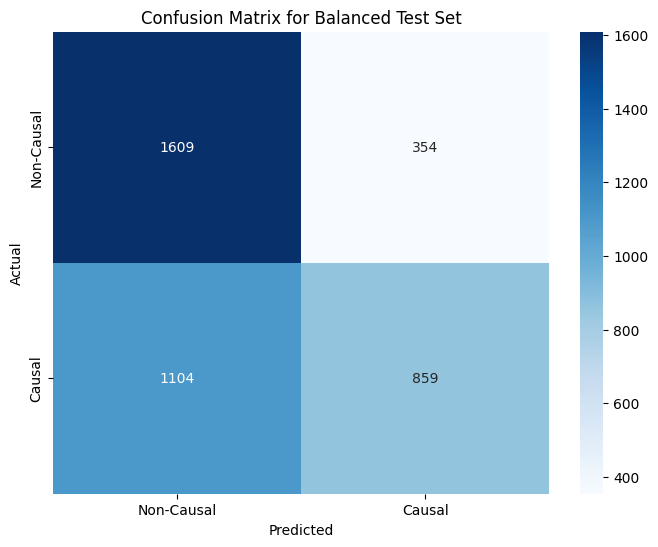

Misclassified sentences saved to Balanced_Test_Set_misclassified.csv

Evaluating on SSC Test Set...


/tmp/ipykernel_30/3287593723.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Results for SSC Test Set:
Accuracy: 0.4688
Precision: 0.3750
Recall: 0.0938
F1 Score: 0.1500



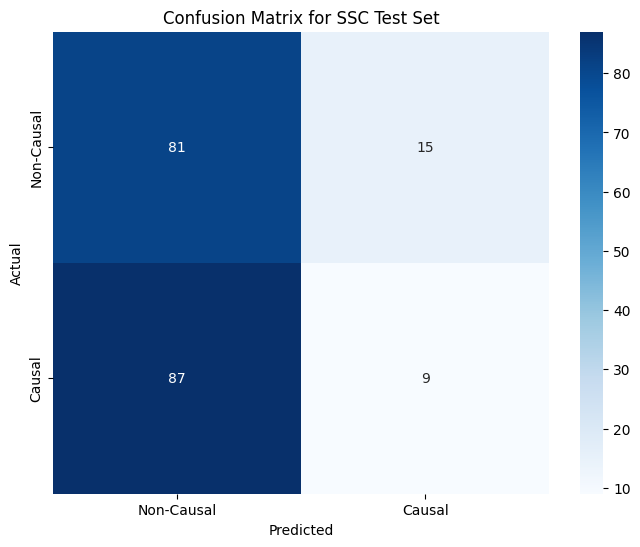

Misclassified sentences saved to SSC_Test_Set_misclassified.csv



In [30]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import Trainer

# Function to evaluate and save misclassified sentences
def evaluate_model_on_test_set(model, tokenizer, test_dataset, dataset_name, output_csv_path):
    test_dataset_sampled = test_dataset.shuffle(seed=42)
    
    # Tokenize test dataset
    tokenized_test = test_dataset_sampled.map(
        lambda x: tokenizer(x['sentence'], truncation=True, padding="max_length", max_length=512),
        batched=True
    )
    tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Create a temporary Trainer without wandb for evaluation
    eval_trainer = Trainer(
        model=model,
        args=training_args,  # Use the same training arguments
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Perform evaluation
    eval_trainer.model.eval()
    outputs = eval_trainer.predict(tokenized_test)

    # Extract predictions and labels
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    print(f"Validation Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Causal", "Causal"], yticklabels=["Non-Causal", "Causal"])
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Misclassified sentences (including source column)
    misclassified = []
    for i in range(len(labels)):
        if labels[i] != predictions[i]:
            misclassified.append({
                'sentence': test_dataset_sampled[i]['sentence'],
                'true_label': labels[i],
                'predicted_label': predictions[i],
                'source': test_dataset_sampled[i]['source']  # Include source column
            })
    
    # Save misclassified sentences to CSV
    misclassified_df = pd.DataFrame(misclassified)
    misclassified_df.to_csv(output_csv_path, index=False)
    print(f"Misclassified sentences saved to {output_csv_path}\n")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "misclassified": misclassified
    }

# Example usage: Evaluate the model on all test sets and save misclassified sentences
test_results = {}
for test_name, test_dataset in zip(
    ["Balanced Test Set", "SSC Test Set"],
    [datasets['test'], datasets['test_ssc']]
):
    print(f"Evaluating on {test_name}...")
    output_csv_path = f"{test_name.replace(' ', '_')}_misclassified.csv"
    test_results[test_name] = evaluate_model_on_test_set(model, tokenizer, test_dataset, test_name, output_csv_path)


Evaluating on SSC Test Set...


Map:   0%|          | 0/192 [00:00<?, ? examples/s]

/tmp/ipykernel_30/3421953313.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Results for SSC Test Set:
Accuracy: 0.4688
Precision: 0.3750
Recall: 0.0938
F1 Score: 0.1500



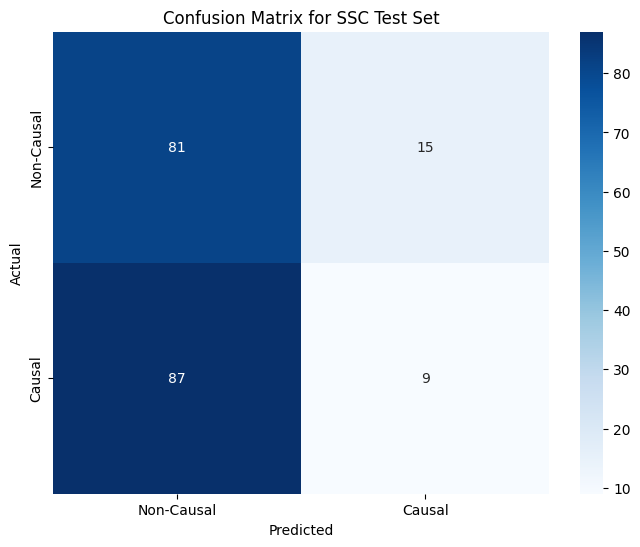

Misclassified sentences saved to SSC_Test_Set_misclassified.csv



In [29]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import Trainer

# Function to evaluate and save misclassified sentences
def evaluate_model_on_test_set(model, tokenizer, test_dataset, dataset_name, output_csv_path):
    # Randomly sample 100 entries from the test dataset
    test_dataset_sampled = test_dataset.shuffle(seed=42)
    
    # Tokenize test dataset
    tokenized_test = test_dataset_sampled.map(
        lambda x: tokenizer(x['sentence'], truncation=True, padding="max_length", max_length=512),
        batched=True
    )
    tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    training_args.eval_strategy = "no" 

    # Create a temporary Trainer without wandb for evaluation
    eval_trainer = Trainer(
        model=model,
        args=training_args,  # Use the same training arguments
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Perform evaluation
    eval_trainer.model.eval()
    outputs = eval_trainer.predict(tokenized_test)

    # Extract predictions and labels
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    print(f"Validation Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Causal", "Causal"], yticklabels=["Non-Causal", "Causal"])
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Misclassified sentences (including source column)
    misclassified = []
    for i in range(len(labels)):
        if labels[i] != predictions[i]:
            misclassified.append({
                'sentence': test_dataset_sampled[i]['sentence'],
                'true_label': labels[i],
                'predicted_label': predictions[i],
                'source': test_dataset_sampled[i]['source']  # Include source column
            })
    
    # Save misclassified sentences to CSV
    misclassified_df = pd.DataFrame(misclassified)
    misclassified_df.to_csv(output_csv_path, index=False)
    print(f"Misclassified sentences saved to {output_csv_path}\n")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "misclassified": misclassified
    }

# Evaluate the model on all test sets and save misclassified sentences
test_results = {}
for test_name, test_dataset in zip(
    ["SSC Test Set"],
    [datasets['test_ssc']]
):
    print(f"Evaluating on {test_name}...")
    output_csv_path = f"{test_name.replace(' ', '_')}_misclassified.csv"
    test_results[test_name] = evaluate_model_on_test_set(model, tokenizer, test_dataset, test_name, output_csv_path)


# 3 level classification

In [10]:
from datasets import load_dataset, DatasetDict

def load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path):
    """
    Load train, balanced test, and imbalanced test datasets from CSV files.
    """
    try:
        # Load the datasets from CSV
        train_dataset = load_dataset('csv', data_files=train_file_path)['train']
        test_dataset = load_dataset('csv', data_files=test_file_path)['train']
        test_ssc_dataset = load_dataset('csv', data_files=test_ssc_file_path)['train']
        validation_dataset = load_dataset('csv', data_files=validation_file_path)['train']
        
        print("Datasets Loaded Successfully.")
        
        # Create a DatasetDict
        dataset_dict = DatasetDict({
            'train': train_dataset,
            'validation': validation_dataset,
            'test': test_dataset,
            'test_ssc': test_ssc_dataset
        })

        return dataset_dict

    except Exception as e:
        print(f"Error loading datasets: {str(e)}")
        return None

# Define paths to your dataset CSV files
train_file_path = '/kaggle/input/3-classfication/3_balanced_trainv2.csv'  
validation_file_path = '//kaggle/input/3-classfication/3_balanced_valv2.csv'
test_file_path = '/kaggle/input/3-classfication/3_balanced_testv2.csv'
test_ssc_file_path = '/kaggle/input/3-classfication/3_ssc_testv2.csv'

# Load the datasets
datasets = load_datasets(train_file_path, validation_file_path, test_file_path, test_ssc_file_path)

# Check if datasets are loaded correctly
if datasets:
    print("Datasets loaded successfully!")
else:
    print("Failed to load datasets.")


Generating train split: 0 examples [00:00, ? examples/s]

Datasets Loaded Successfully.
Datasets loaded successfully!


In [11]:
import pandas as pd

def show_label_and_source_distribution(datasets):
    # Check label and source distribution for each dataset in the dataset_dict
    for split, dataset in datasets.items():
        # Convert dataset to a Pandas DataFrame to easily work with
        df = pd.DataFrame(dataset)
        
        # Check if the label column exists and print the distribution
        if 'label' in df.columns:
            print(f"Label distribution for {split} dataset:")
            print(df['label'].value_counts())
            print("\n")
        else:
            print(f"No label column found in {split} dataset.\n")
        
        # Print the distribution of sentences per source
        if 'source' in df.columns:
            print(f"Sentence distribution per source for {split} dataset:")
            print(df['source'].value_counts())
            print("\n")
        else:
            print(f"No source column found in {split} dataset.\n")

# Call the function to display both label and source distributions for each dataset
show_label_and_source_distribution(datasets)


Label distribution for train dataset:
label
2    465
1    465
3    465
Name: count, dtype: int64


Sentence distribution per source for train dataset:
source
press_release    577
pubmed           539
ssc              279
Name: count, dtype: int64


Label distribution for validation dataset:
label
3    67
2    67
1    67
Name: count, dtype: int64


Sentence distribution per source for validation dataset:
source
press_release    83
pubmed           74
ssc              44
Name: count, dtype: int64


Label distribution for test dataset:
label
1    133
3    133
2    133
Name: count, dtype: int64


Sentence distribution per source for test dataset:
source
pubmed           156
press_release    145
ssc               98
Name: count, dtype: int64


Label distribution for test_ssc dataset:
label
3    46
2    40
1    12
Name: count, dtype: int64


Sentence distribution per source for test_ssc dataset:
source
ssc    98
Name: count, dtype: int64




In [12]:
datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 1395
    })
    validation: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 201
    })
    test: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 399
    })
    test_ssc: Dataset({
        features: ['sentence', 'label', 'source'],
        num_rows: 98
    })
})

In [13]:
print(set(datasets['train']['label']))  
print(set(datasets['validation']['label']))  
print(set(datasets['test_ssc']['label']))  

{1, 2, 3}
{1, 2, 3}
{1, 2, 3}


In [14]:
# Define a function to remap labels: 1 -> 0, 2 -> 1, 3 -> 2
def remap_labels(example):
    example['label'] = example['label'] - 1
    return example

# Apply the remap_labels function to the train, validation, and test datasets
datasets['train'] = datasets['train'].map(remap_labels)
datasets['validation'] = datasets['validation'].map(remap_labels)
datasets['test'] = datasets['test'].map(remap_labels)
datasets['test_ssc'] = datasets['test_ssc'].map(remap_labels)
print(set(datasets['train']['label']))  
print(set(datasets['validation']['label'])) 
print(set(datasets['test']['label'])) 
print(set(datasets['test_ssc']['label']))  

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

{0, 1, 2}
{0, 1, 2}
{0, 1, 2}
{0, 1, 2}


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", num_labels=3)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
torch.cuda.empty_cache()  # Clears the GPU memory cache


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set the pad token to be the same as eos_token if it is not already defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Confirm pad_token and eos_token are set
print(f"Pad Token: {tokenizer.pad_token}")
print(f"EOS Token: {tokenizer.eos_token}")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'], 
        truncation=True, 
        padding="max_length",  # ensure padding is applied
        max_length=100,
        return_tensors='pt'    # return pytorch tensors
    )

# Assuming datasets is already loaded as a DatasetDict
# Tokenize the datasets
datasets = datasets.map(tokenize_function, batched=True)

# Set the format for PyTorch
datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Print a sample to ensure everything is set up correctly
print(datasets['train'][0])

Pad Token: <|eot_id|>
EOS Token: <|eot_id|>


Map:   0%|          | 0/201 [00:00<?, ? examples/s]

{'label': tensor(1), 'input_ids': tensor([128000,   1687,   1101,   1505,    430,    279,   2237,    315,  19035,
          1234,   2204,   1670,   2671,    374,  16614,    311,    279,    955,
           315,    279,    586,  11822,   1847,  20011,     13, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

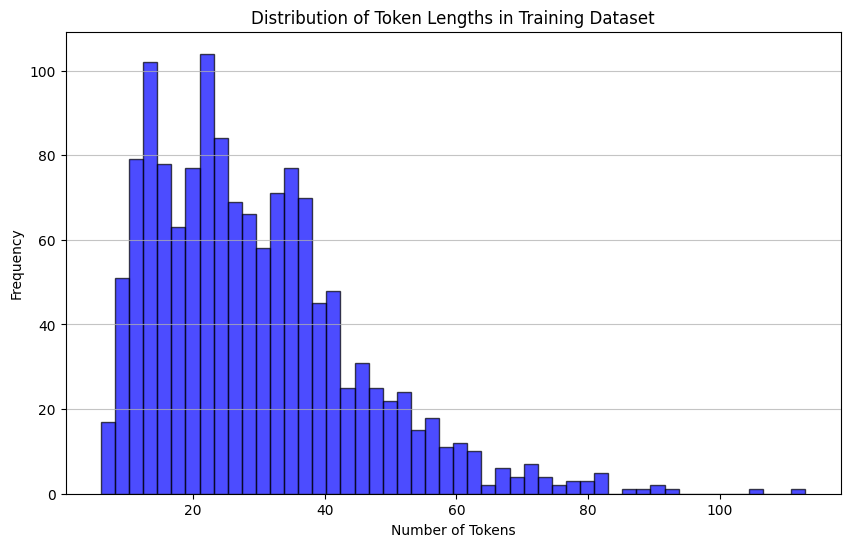

Max token length: 113
Min token length: 6
Average token length: 29.40


In [18]:
import matplotlib.pyplot as plt

# Calculate token length distribution for the training dataset
token_lengths = [len(tokenizer.tokenize(sentence)) for sentence in datasets['train']['sentence']]

# Plot the distribution of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, color="blue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Token Lengths in Training Dataset")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# Print summary statistics
print(f"Max token length: {max(token_lengths)}")
print(f"Min token length: {min(token_lengths)}")
print(f"Average token length: {sum(token_lengths) / len(token_lengths):.2f}")


In [19]:
import os
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import multiprocessing

# Use 'spawn' to avoid fork-related issues
multiprocessing.set_start_method("spawn", force=True)

# Initialize wandb
wandb.init(
    project="llama_causality_classification",  # Set your project name
    name="llama-small-dataset",               # Customize the run name
    config={
        "model_name": "meta-llama/Llama-3.2-1B-Instruct",
        "learning_rate": 2e-5,
        "batch_size": 1,
        "gradient_accumulation_steps": 4,
        "epochs": 1
    }
)

# Disable tokenizer parallelism to avoid multiprocessing issues
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# # Select only 200 training samples and 100 validation samples
# if datasets:
#     datasets['train'] = datasets['train'].shuffle(seed=42).select(range(50))
#     datasets['validation'] = datasets['validation'].shuffle(seed=42).select(range(10))

# Model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = prepare_model_for_kbit_training(model)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["q_proj", "k_proj", "v_proj"],
)
model = get_peft_model(model, lora_config)

# Tokenization
def tokenize_function(examples):
    # Add an instruction to the sentence
    instruction = "Classify the following sentence as 'Causal' or 'Non-Causal': "
    inputs = [instruction + sentence for sentence in examples['sentence']]
    
    # Tokenize the instruction + sentence
    return tokenizer(inputs, truncation=True, padding="max_length", max_length=100)

# Tokenize datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Debugging dataset structure
print("Formatted dataset column names:")
for split in tokenized_datasets.keys():
    print(f"{split} columns: {tokenized_datasets[split].column_names}")

print("Sample from tokenized train dataset:")
print(tokenized_datasets['train'][0])

# Define the custom compute_metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(-1)  # Get the predicted class (0, 1, or 2)
    labels = p.label_ids  # True labels
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')  # Change to macro for multi-class
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    fp16=True,
    gradient_checkpointing=True,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=1000,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to="wandb",  # Log metrics to wandb
    dataloader_num_workers=2,
    warmup_steps=100,
    optim="adamw_torch",
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # Pass the custom metrics function
)

wandb: Currently logged in as: tessa2712 (tessa2712-tu-eindhoven) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Formatted dataset column names:
train columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
validation columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
test columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
test_ssc columns: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
Sample from tokenized train dataset:
{'label': tensor(1), 'input_ids': tensor([128000,   1999,   1463,    279,   2768,  11914,    439,    364,     34,
         80174,      6,    477,    364,   8284,   7813,  80174,   1232,   1226,
          1101,   1505,    430,    279,   2237,    315,  19035,   1234,   2204,
          1670,   2671,    374,  16614,    311,    279,    955,    315,    279,
           586,  11822,   1847,  20011,     13, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
        128009, 12

/tmp/ipykernel_1199/665097049.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Training will be done on the GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training will be done on CPU.")

CUDA_LAUNCH_BLOCKING=1


Training will be done on the GPU: Tesla T4


In [22]:
# Train the model
trainer.train()
trainer.save_model("./final_model")
eval_results = trainer.evaluate()
print(eval_results)

# Finalize wandb logging
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Wa

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.285151,0.348259,0.346200,0.346472,0.348259


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

{'eval_loss': 1.2851507663726807, 'eval_accuracy': 0.3482587064676617, 'eval_f1': 0.34620009620009623, 'eval_precision': 0.3464716074885567, 'eval_recall': 0.34825870646766166, 'eval_runtime': 25.8822, 'eval_samples_per_second': 7.766, 'eval_steps_per_second': 0.27, 'epoch': 1.0}


eval/accuracy,▁▁
eval/f1,▁▁
eval/loss,▁▁
eval/precision,▁▁
eval/recall,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁
train/global_step,▁▁▁
eval/accuracy,0.34826


Evaluating on Balanced Test Set...


/tmp/ipykernel_1199/1979499040.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Results for Balanced Test Set:
Accuracy: 0.3358
Precision (Macro): 0.3578
Recall (Macro): 0.3358
F1 Score (Macro): 0.3026



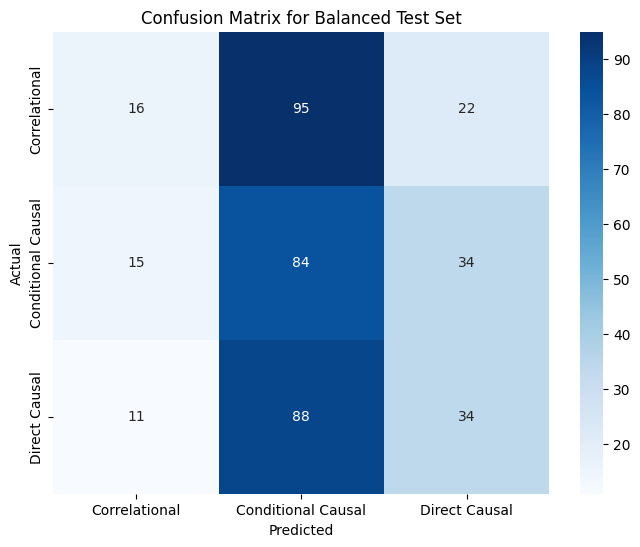

Classification Report:
Class               Precision   Recall    F1-Score    Support
Correlational       0.38        0.12      0.18        133
Conditional Causal  0.31        0.63      0.42        133
Direct Causal       0.38        0.26      0.30        133
accuracy            0.34        
macro avg           0.36        0.34      0.30        399
weighted avg        0.36        0.34      0.30        399
Misclassified sentences saved to Balanced_Test_Set_misclassified_3.csv

Evaluating on SSC Test Set...


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

/tmp/ipykernel_1199/1979499040.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Results for SSC Test Set:
Accuracy: 0.4388
Precision (Macro): 0.3619
Recall (Macro): 0.3484
F1 Score (Macro): 0.3456



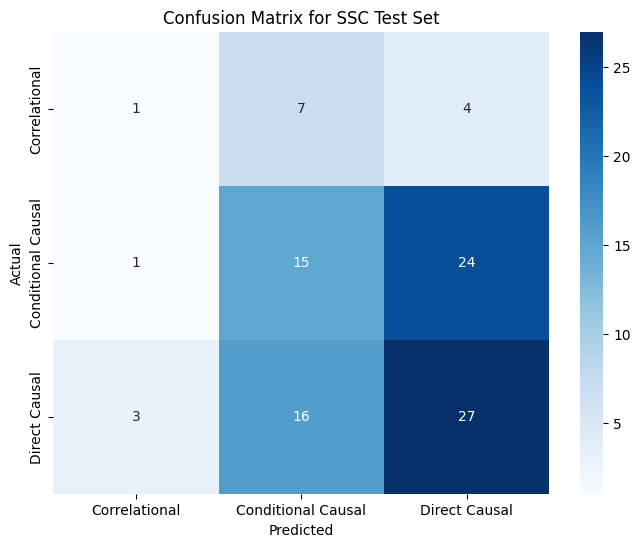

Classification Report:
Class               Precision   Recall    F1-Score    Support
Correlational       0.20        0.08      0.12        12
Conditional Causal  0.39        0.38      0.38        40
Direct Causal       0.49        0.59      0.53        46
accuracy            0.44        
macro avg           0.36        0.35      0.35        98
weighted avg        0.42        0.44      0.42        98
Misclassified sentences saved to SSC_Test_Set_misclassified_3.csv



In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import Trainer

# Function to evaluate and save misclassified sentences
def evaluate_model_on_test_set(model, tokenizer, test_dataset, dataset_name, output_csv_path):
    
    # Tokenize test dataset
    tokenized_test = test_dataset.map(
        lambda x: tokenizer(x['sentence'], truncation=True, padding="max_length", max_length=100),
        batched=True
    )
    tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label', 'sentence', 'source'])
    training_args.eval_strategy = "no" 
    # Create a temporary Trainer without wandb for evaluation
    eval_trainer = Trainer(
        model=model,
        args=training_args,  # Use the same training arguments
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Perform evaluation
    eval_trainer.model.eval()
    outputs = eval_trainer.predict(tokenized_test)

    # Extract predictions and labels
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    print(f"Validation Results for {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Correlational", "Conditional Causal", "Direct Causal"], yticklabels=["Correlational", "Conditional Causal", "Direct Causal"])
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    class_report = classification_report(labels, predictions, target_names=["Correlational", "Conditional Causal", "Direct Causal"], output_dict=True)
    print("Classification Report:")
    print(f"{'Class':<20}{'Precision':<12}{'Recall':<10}{'F1-Score':<12}{'Support'}")
    for class_name in class_report.keys():
        if class_name != 'accuracy' and class_name != 'macro avg' and class_name != 'weighted avg':
            print(f"{class_name:<20}{class_report[class_name]['precision']:<12.2f}{class_report[class_name]['recall']:<10.2f}{class_report[class_name]['f1-score']:<12.2f}{class_report[class_name]['support']}")
    print(f"{'accuracy':<20}{class_report['accuracy']:<12.2f}")
    print(f"{'macro avg':<20}{class_report['macro avg']['precision']:<12.2f}{class_report['macro avg']['recall']:<10.2f}{class_report['macro avg']['f1-score']:<12.2f}{class_report['macro avg']['support']}")
    print(f"{'weighted avg':<20}{class_report['weighted avg']['precision']:<12.2f}{class_report['weighted avg']['recall']:<10.2f}{class_report['weighted avg']['f1-score']:<12.2f}{class_report['weighted avg']['support']}")
    
    # Misclassified sentences (including source column)
    misclassified = []
    for i in range(len(labels)):
        if labels[i] != predictions[i]:
            misclassified.append({
                'sentence': tokenized_test[i]['sentence'],
                'true_label': labels[i],
                'predicted_label': predictions[i],
                'source': tokenized_test[i]['source']  # Include source column
            })
    
    # Save misclassified sentences to CSV
    misclassified_df = pd.DataFrame(misclassified)
    misclassified_df.to_csv(output_csv_path, index=False)
    print(f"Misclassified sentences saved to {output_csv_path}\n")
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "misclassified": misclassified,
        "classification_report": class_report
    }

# Example usage: Evaluate the model on all test sets and save misclassified sentences
test_results = {}
#    ["Balanced Test Set", "SSC Test Set"],
# [datasets['test'], datasets['test_ssc']]
#
for test_name, test_dataset in zip(
    ["Balanced Test Set", "SSC Test Set"],
    [datasets['test'], datasets['test_ssc']]
):
    print(f"Evaluating on {test_name}...")
    output_csv_path = f"{test_name.replace(' ', '_')}_misclassified_3.csv"
    test_results[test_name] = evaluate_model_on_test_set(model, tokenizer, test_dataset, test_name, output_csv_path)


In [23]:
# Print the column names to verify 'sentence' is present
print("Columns in test dataset:", test_dataset.column_names)


Columns in test dataset: ['sentence', 'label', 'source', 'input_ids', 'attention_mask']
